In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from meteostat import Point, Hourly
from datetime import datetime
import data_processing as dp
from sklearn.ensemble import IsolationForest
import utils
import geopandas as gpd
from shapely.geometry import LineString



# Bike data

In [2]:
bike_data = pd.read_csv('data/boston/202301-bluebikes-tripdata.csv')

In [3]:
bike_data.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,postal code
0,250,2023-01-01 00:02:54.0800,2023-01-01 00:07:04.4100,36,Copley Square - Dartmouth St at Boylston St,42.349928,-71.077392,21,Prudential Center - 101 Huntington Ave,42.346520,-71.080658,4213,Subscriber,02115
1,489,2023-01-01 00:10:33.3100,2023-01-01 00:18:42.3690,372,Boylston St at Exeter St,42.349589,-71.079468,404,Mass Ave T Station,42.341356,-71.083370,3153,Customer,NaN
2,461,2023-01-01 00:10:49.9130,2023-01-01 00:18:31.1280,372,Boylston St at Exeter St,42.349589,-71.079468,404,Mass Ave T Station,42.341356,-71.083370,3431,Customer,02186
3,1065,2023-01-01 00:13:58.0640,2023-01-01 00:31:43.5090,58,Mugar Way at Beacon St,42.355536,-71.072869,345,Park Plaza at Charles St S.,42.351828,-71.067811,4398,Customer,NaN
4,601,2023-01-01 00:14:02.6130,2023-01-01 00:24:03.8950,50,Boylston St at Berkeley St,42.351142,-71.073292,374,Tremont St at Hamilton Pl,42.356683,-71.061666,7964,Subscriber,02138


In [4]:
bike_data.shape

(140340, 14)

In [5]:
bike_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140340 entries, 0 to 140339
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   tripduration             140340 non-null  int64  
 1   starttime                140340 non-null  object 
 2   stoptime                 140340 non-null  object 
 3   start station id         140340 non-null  int64  
 4   start station name       140340 non-null  object 
 5   start station latitude   140340 non-null  float64
 6   start station longitude  140340 non-null  float64
 7   end station id           140340 non-null  int64  
 8   end station name         140340 non-null  object 
 9   end station latitude     140340 non-null  float64
 10  end station longitude    140340 non-null  float64
 11  bikeid                   140340 non-null  int64  
 12  usertype                 140340 non-null  object 
 13  postal code              131990 non-null  object 
dtypes: f

# Weather data


temp: Temperature in °C. You can use this for temperature categorization (cold, hot, etc.).

dwpt (Dew Point): Shows the temperature at which air reaches saturation. It can help assess humidity.

rhum (Relative Humidity): Indicates moisture in the air. High humidity may correlate with foggy or uncomfortable conditions.

prcp (Precipitation): The amount of rain in mm. This is a critical feature, as rain could reduce bike usage.

snow: Amount of snowfall. If available, this feature can indicate bad weather that impacts mobility.

wdir (Wind Direction): Could help identify patterns where high winds affect bike riding.

wspd (Wind Speed): Wind speed in km/h. Windy conditions might also explain anomalies, such as shorter or fewer trips.

wpgt (Wind Gust): This represents wind gust speed in km/h, indicating the maximum short burst of wind speed during the hour. 

pres (Pressure): Atmospheric pressure, useful for assessing weather patterns (e.g., high pressure = clear skies).

coco (Weather Condition Code): Encodes the general weather condition (clear, cloudy, rain, snow, etc.).

tsun (Sunshine): Amount of sunshine (though it seems missing here).

In [6]:
boston = Point(42.3601, -71.0589)  # Latitude and Longitude for Boston

In [7]:
start = datetime(2023, 1, 1)
end = datetime(2023, 1, 31)

weather_data_hourly = Hourly(boston, start, end)
weather_data_hourly = weather_data_hourly.fetch()

print(weather_data_hourly.head())

                     temp  dwpt   rhum  prcp  snow   wdir  wspd  wpgt    pres  \
time                                                                            
2023-01-01 00:00:00  11.1  11.1  100.0   1.2   NaN  180.0  13.0   NaN  1010.4   
2023-01-01 01:00:00  11.1  11.1  100.0   0.3   NaN  190.0  11.2   NaN  1008.9   
2023-01-01 02:00:00  11.7  11.7  100.0   0.5   NaN  210.0  13.0   NaN  1008.2   
2023-01-01 03:00:00  11.1  11.1  100.0   1.8   NaN  190.0  11.2   NaN  1006.2   
2023-01-01 04:00:00  12.2  12.2  100.0   2.3   NaN  220.0  16.6   NaN  1005.3   

                     tsun  coco  
time                             
2023-01-01 00:00:00   NaN   7.0  
2023-01-01 01:00:00   NaN   7.0  
2023-01-01 02:00:00   NaN   7.0  
2023-01-01 03:00:00   NaN   7.0  
2023-01-01 04:00:00   NaN   7.0  


In [8]:
weather_data_hourly = weather_data_hourly.reset_index()

In [9]:
# Ensure both are in datetime format
bike_data['starttime'] = pd.to_datetime(bike_data['starttime'])
weather_data_hourly['time'] = pd.to_datetime(weather_data_hourly['time'])

bike_weather_data = pd.merge_asof(bike_data, weather_data_hourly, left_on='starttime', right_on='time', direction='nearest')

print(bike_weather_data.head())


   tripduration               starttime                  stoptime  \
0           250 2023-01-01 00:02:54.080  2023-01-01 00:07:04.4100   
1           489 2023-01-01 00:10:33.310  2023-01-01 00:18:42.3690   
2           461 2023-01-01 00:10:49.913  2023-01-01 00:18:31.1280   
3          1065 2023-01-01 00:13:58.064  2023-01-01 00:31:43.5090   
4           601 2023-01-01 00:14:02.613  2023-01-01 00:24:03.8950   

   start station id                           start station name  \
0                36  Copley Square - Dartmouth St at Boylston St   
1               372                     Boylston St at Exeter St   
2               372                     Boylston St at Exeter St   
3                58                       Mugar Way at Beacon St   
4                50                   Boylston St at Berkeley St   

   start station latitude  start station longitude  end station id  \
0               42.349928               -71.077392              21   
1               42.349589           

In [10]:
# Check for NaN values 
print(bike_weather_data.isnull().sum())
print(len(bike_weather_data))

tripduration                    0
starttime                       0
stoptime                        0
start station id                0
start station name              0
start station latitude          0
start station longitude         0
end station id                  0
end station name                0
end station latitude            0
end station longitude           0
bikeid                          0
usertype                        0
postal code                  8350
time                            0
temp                            0
dwpt                            0
rhum                            0
prcp                            0
snow                       140340
wdir                            0
wspd                            0
wpgt                       140340
pres                            0
tsun                       140340
coco                            0
dtype: int64
140340


In [11]:
bike_weather_data = bike_weather_data.drop(columns=['snow', 'wpgt', 'tsun'])


Code	Weather Condition

1	Clear

2	Fair

3	Cloudy

4	Overcast

5	Fog

6	Freezing Fog

7	Light Rain

8	Rain

9	Heavy Rain

10	Freezing Rain

11	Heavy Freezing Rain

12	Sleet

13	Heavy Sleet

14	Light Snowfall

15	Snowfall

16	Heavy Snowfall

17	Rain Shower

18	Heavy Rain Shower

19	Sleet Shower

20	Heavy Sleet Shower

21	Snow Shower

22	Heavy Snow Shower

23	Lightning

24	Hail

25	Thunderstorm

26	Heavy Thunderstorm

27	Storm

# Data Visualizations

In [12]:
# Domain-specific cutoffs for trip durations in bike sharing
bike_weather_data['tripduration_type'] = np.where(
    bike_weather_data['tripduration'] < 900, "very_short_trip",  # Less than 15 minutes
    np.where(
        (bike_weather_data['tripduration'] >= 900) & (bike_weather_data['tripduration'] < 3600), "short_trip",  # 15 minutes to 1 hour
        np.where(
            (bike_weather_data['tripduration'] >= 3600) & (bike_weather_data['tripduration'] <= 6 * 3600), "long_trip",  # 1 to 6 hours
            "very_long_trip"  # More than 6 hours
        )
    )
)


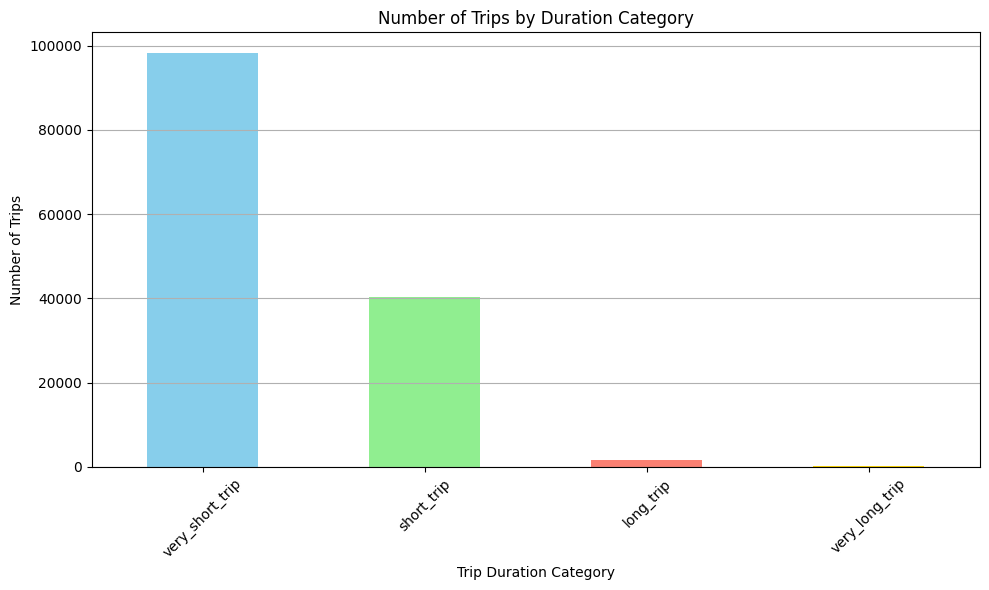

In [13]:
# Count the number of trips in each category
trip_counts = bike_weather_data['tripduration_type'].value_counts()

plt.figure(figsize=(10, 6))
trip_counts.plot(kind='bar', color=['skyblue', 'lightgreen', 'salmon', 'gold'])
plt.title('Number of Trips by Duration Category')
plt.xlabel('Trip Duration Category')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.tight_layout()
plt.show()

In [34]:
trip_counts

tripduration_type
short_trip      138477
average_trip      1735
long_trip          128
Name: count, dtype: int64

In [35]:
bike_weather_data = dp.distances_feature(bike_weather_data)
bike_weather_data = dp.speed_feature(bike_weather_data)

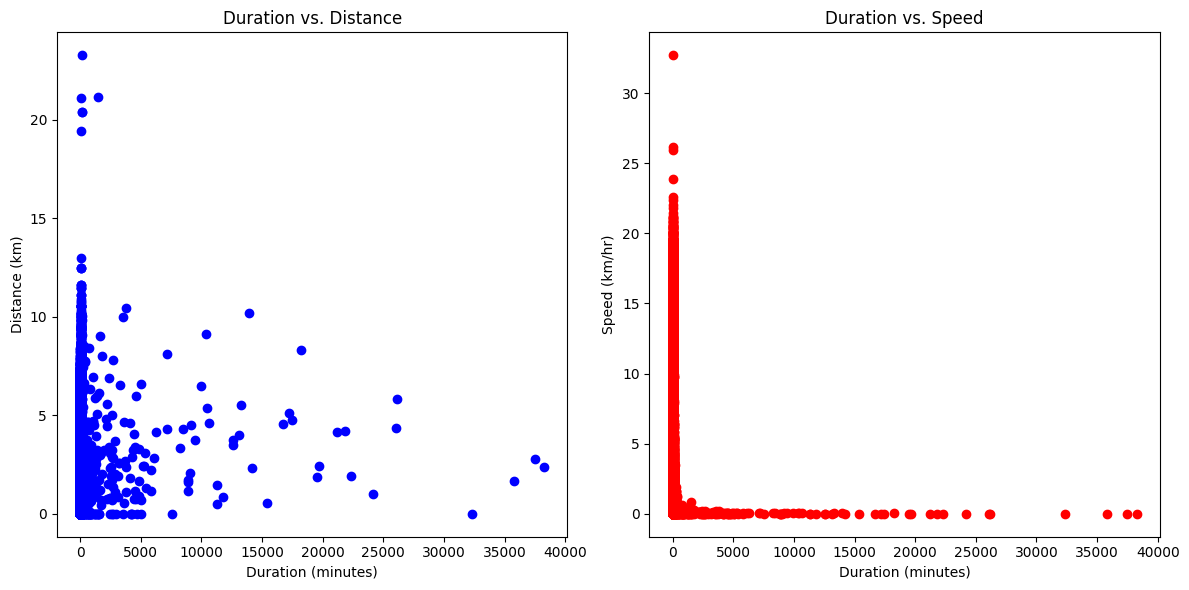

In [59]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  

axs[0].scatter(bike_weather_data['tripduration'] / 60, bike_weather_data['distance'], color='b')
axs[0].set_xlabel('Duration (minutes)')
axs[0].set_ylabel('Distance (km)')
axs[0].set_title('Duration vs. Distance')

axs[1].scatter(bike_weather_data['tripduration'] / 60, bike_weather_data['speed'], color='r')
axs[1].set_xlabel('Duration (minutes)')
axs[1].set_ylabel('Speed (km/hr)')
axs[1].set_title('Duration vs. Speed')

plt.tight_layout()

plt.show()

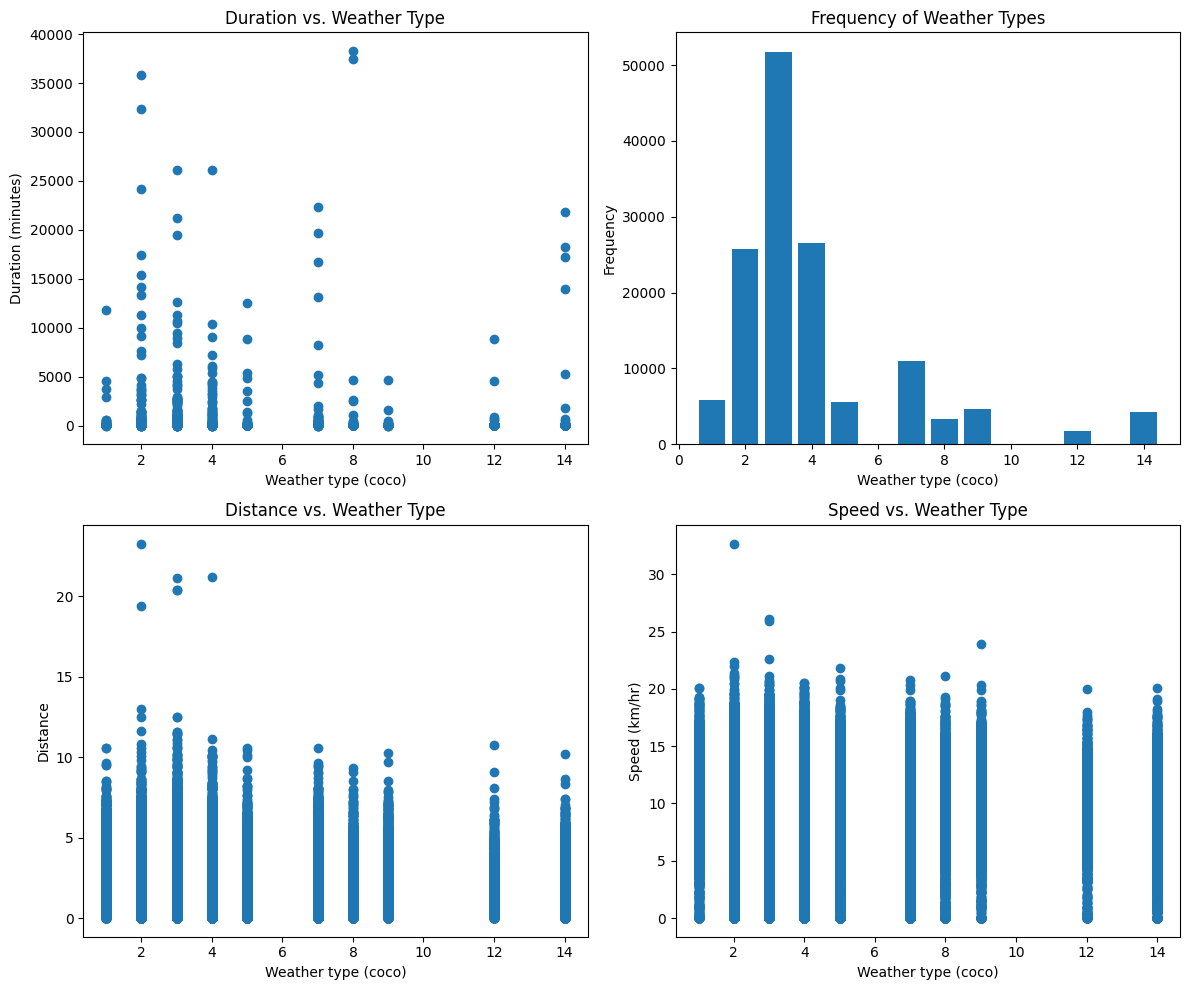

In [57]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0, 0].scatter(bike_weather_data['coco'], bike_weather_data['tripduration'] / 60)
axs[0, 0].set_ylabel('Duration (minutes)')
axs[0, 0].set_xlabel('Weather type (coco)')
axs[0, 0].set_title('Duration vs. Weather Type')

axs[0, 1].bar(bike_weather_data['coco'].value_counts().index, bike_weather_data['coco'].value_counts().values)
axs[0, 1].set_ylabel('Frequency')
axs[0, 1].set_xlabel('Weather type (coco)')
axs[0, 1].set_title('Frequency of Weather Types')

axs[1, 0].scatter(bike_weather_data['coco'], bike_weather_data['distance'])
axs[1, 0].set_ylabel('Distance')
axs[1, 0].set_xlabel('Weather type (coco)')
axs[1, 0].set_title('Distance vs. Weather Type')

bike_weather_data['speed'] = bike_weather_data['distance'] / (bike_weather_data['tripduration'] / 3600)  # Convert tripduration to hours for speed
axs[1, 1].scatter(bike_weather_data['coco'], bike_weather_data['speed'])
axs[1, 1].set_ylabel('Speed (km/hr)')
axs[1, 1].set_xlabel('Weather type (coco)')
axs[1, 1].set_title('Speed vs. Weather Type')

plt.tight_layout()

plt.show()

## Boxplots of continious variables

In [14]:
bike_weather_data = dp.process_data(city_name = 'boston', start = datetime(2023, 1, 1), end = datetime(2023, 1, 31), pca=False)

Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326



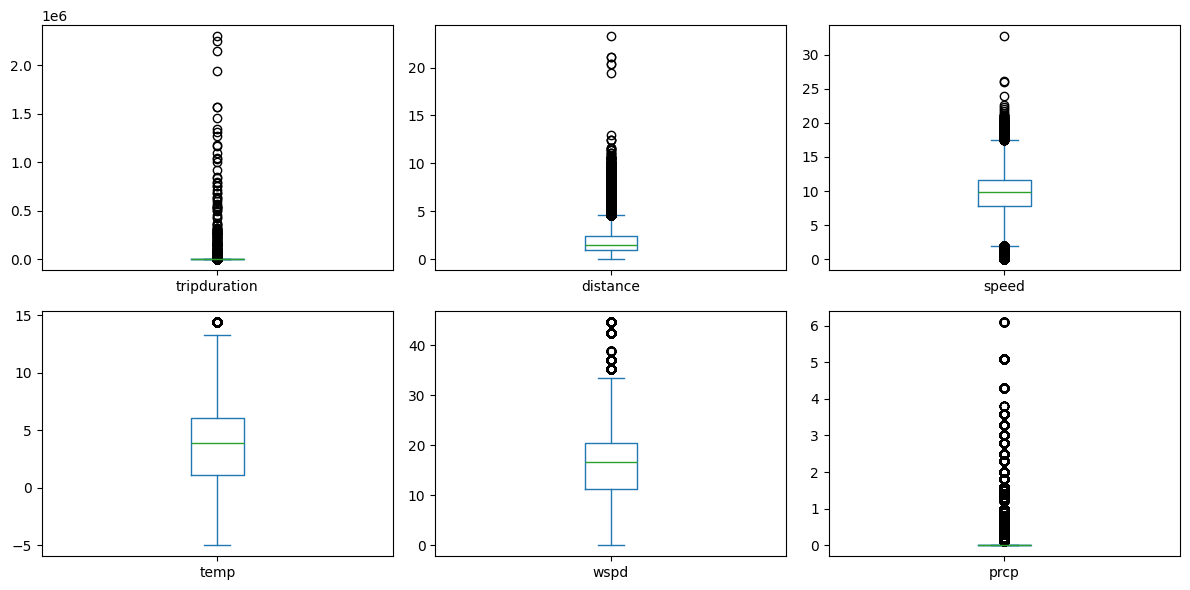

In [15]:
continuous_features = ['tripduration', 'distance', 'speed', 'temp', 'wspd', 'prcp']
categorical_features = ['user_type_encoded', 'coco', 'start_hour', 'start_dayofweek', 'start_month']

# Plot box plots for continuous features
bike_weather_data[continuous_features].plot(kind='box', subplots=True, layout=(2, 3), figsize=(12, 6))
plt.tight_layout()
plt.show()


# Tuning the contamination

In [2]:
bike_weather_data = dp.process_data(city_name = 'boston', start = datetime(2023, 1, 1), end = datetime(2023, 1, 31), pca=False)


In [3]:
Y = bike_weather_data['special_day']
X = bike_weather_data.drop(columns=['special_day'])

In [8]:
contamination_values = np.linspace(0.04, 0.08, 20)  
# contamination_values = [0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.12, 0.15, 0.18, 0.2, 0.25, 0.3, 0.35, 0.4]
special_day_precisions = []


In [9]:
for contamination in contamination_values:
    # Initialize and train Isolation Forest model
    iso_forest = IsolationForest(
        contamination=contamination, 
        n_estimators=500, 
        max_samples=0.1 
    )
    bike_weather_data['anomaly'] = iso_forest.fit_predict(X)
    
    # Extract anomalies
    anomalies = bike_weather_data[bike_weather_data['anomaly'] == -1]
    
    # Calculate special day precision using the utility function
    precision = utils.calculate_special_day_accuracy(bike_weather_data, anomalies)
    special_day_precisions.append(precision)



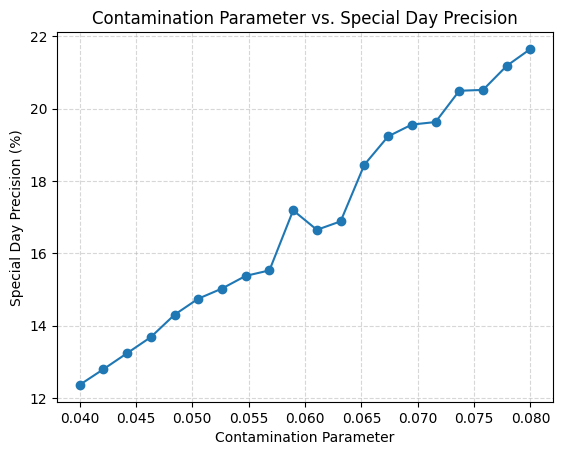

In [10]:
# Plot the contamination parameter vs. special day precision
plt.plot(contamination_values,special_day_precisions, marker='o')
plt.xlabel('Contamination Parameter')
plt.ylabel('Special Day Precision (%)')
plt.title('Contamination Parameter vs. Special Day Precision')
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.show()

# Neighborhood analysis

In [ ]:
dp.combine_and_save_neighborhoods()


In [2]:
bike_weather_data = dp.process_data(city_name = 'boston', start = datetime(2023, 1, 1), end = datetime(2023, 1, 31), pca=False)


Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326



In [3]:
bike_weather_data

,tripduration,distance,user_type_encoded,speed,temp,wspd,prcp,coco,start_hour,start_dayofweek,...,end_hour,end_dayofweek,end_month,special_day,start_nearby_transit_stops,end_nearby_transit_stops,start_neighborhood,end_neighborhood,start_geometry,end_geometry
0,250,0.464383,1,6.687112,11.1,13.0,1.2,7.0,0,6,...,0,6,1,New Year's Day,2,1,Back Bay,Back Bay,POINT (-71.07739 42.34993),POINT (-71.08066 42.34652)
1,489,0.970031,0,7.141336,11.1,13.0,1.2,7.0,0,6,...,0,6,1,New Year's Day,1,2,Back Bay,Roxbury,POINT (-71.07947 42.34959),POINT (-71.08337 42.34136)
2,461,0.970031,0,7.575083,11.1,13.0,1.2,7.0,0,6,...,0,6,1,New Year's Day,1,2,Back Bay,Roxbury,POINT (-71.07947 42.34959),POINT (-71.08337 42.34136)
3,1065,0.585427,0,1.978907,11.1,13.0,1.2,7.0,0,6,...,0,6,1,New Year's Day,0,1,Beacon Hill,Downtown,POINT (-71.07287 42.35554),POINT (-71.06781 42.35183)
4,601,1.136817,1,6.809552,11.1,13.0,1.2,7.0,0,6,...,0,6,1,New Year's Day,1,2,Back Bay,Downtown,POINT (-71.07329 42.35114),POINT (-71.06167 42.35668)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140335,1512,3.637064,1,8.659676,4.4,0.0,0.0,3.0,23,1,...,0,2,2,None,2,1,Fenway,out_of_area_nearby,POINT (-71.09701 42.34871),POINT (-71.10403 42.381)
140336,350,0.897815,1,9.234664,4.4,0.0,0.0,3.0,23,1,...,23,1,1,None,1,2,The Port,The Port,POINT (-71.09157 42.3629),POINT (-71.0993 42.36861)
140337,2174,3.353297,1,5.552837,4.4,0.0,0.0,3.0,23,1,...,0,2,2,None,0,1,East Cambridge,out_of_area_nearby,POINT (-71.08287 42.36305),POINT (-71.11467 42.34415)
140338,149,0.246788,1,5.962664,4.4,0.0,0.0,3.0,23,1,...,23,1,1,None,0,0,North Cambridge,North Cambridge,POINT (-71.14261 42.39559),POINT (-71.14394 42.3936)


In [4]:
in_area_start = bike_weather_data[bike_weather_data['start_neighborhood'].notna() & 
                            (~bike_weather_data['start_neighborhood'].str.contains('out_of_area'))]
near_out_of_area_start = bike_weather_data[bike_weather_data['start_neighborhood'] == 'out_of_area_nearby']
far_out_of_area_start = bike_weather_data[bike_weather_data['start_neighborhood'] == 'out_of_area_far']

in_area_end = bike_weather_data[bike_weather_data['end_neighborhood'].notna() &
                            (~bike_weather_data['end_neighborhood'].str.contains('out_of_area'))]
near_out_of_area_end = bike_weather_data[bike_weather_data['end_neighborhood'] == 'out_of_area_nearby']
far_out_of_area_end = bike_weather_data[bike_weather_data['end_neighborhood'] == 'out_of_area_far']


In [5]:
len(in_area_start), len(near_out_of_area_start), len(far_out_of_area_start)

(126205, 13596, 539)

See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler


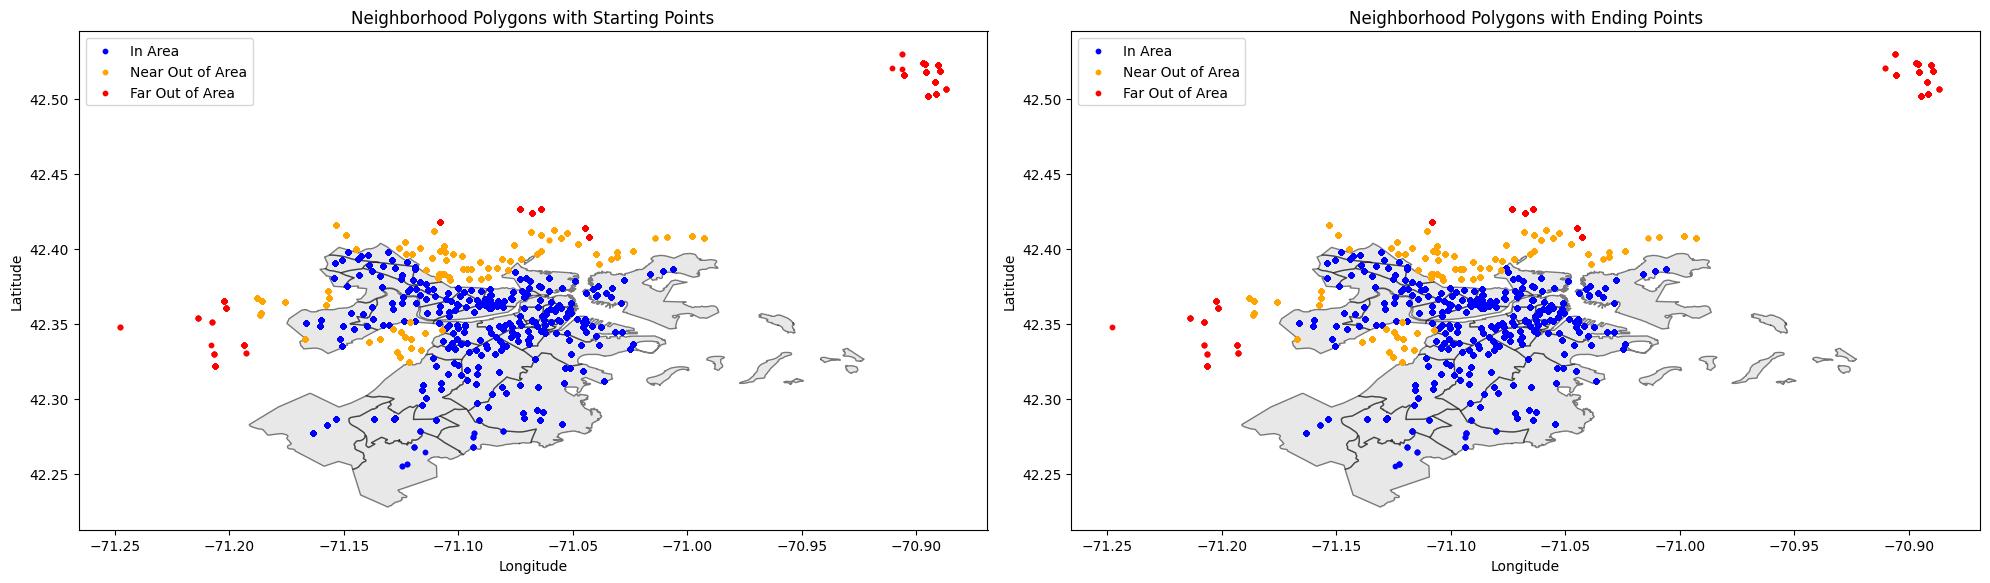

In [18]:
# Load neighborhoods data
neighborhoods = gpd.read_file('boston_cambridge_neighborhoods.geojson')

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Define an equal aspect ratio for both subplots
aspect_ratio = (neighborhoods.total_bounds[3] - neighborhoods.total_bounds[1]) / \
               (neighborhoods.total_bounds[2] - neighborhoods.total_bounds[0])

# Plot starting points
neighborhoods.plot(ax=axes[0], color='lightgrey', edgecolor='black', alpha=0.5, label='Neighborhoods')
if not in_area_start.empty:
    gpd.GeoSeries(in_area_start['start_geometry']).plot(ax=axes[0], color='blue', markersize=10, label='In Area')
if not near_out_of_area_start.empty:
    gpd.GeoSeries(near_out_of_area_start['start_geometry']).plot(ax=axes[0], color='orange', markersize=10, label='Near Out of Area')
if not far_out_of_area_start.empty:
    gpd.GeoSeries(far_out_of_area_start['start_geometry']).plot(ax=axes[0], color='red', markersize=10, label='Far Out of Area')
axes[0].set_title('Neighborhood Polygons with Starting Points')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].set_aspect(aspect_ratio)
axes[0].legend()

# Plot ending points
neighborhoods.plot(ax=axes[1], color='lightgrey', edgecolor='black', alpha=0.5, label='Neighborhoods')
if not in_area_end.empty:
    gpd.GeoSeries(in_area_end['end_geometry']).plot(ax=axes[1], color='blue', markersize=10, label='In Area')
if not near_out_of_area_end.empty:
    gpd.GeoSeries(near_out_of_area_end['end_geometry']).plot(ax=axes[1], color='orange', markersize=10, label='Near Out of Area')
if not far_out_of_area_end.empty:
    gpd.GeoSeries(far_out_of_area_end['end_geometry']).plot(ax=axes[1], color='red', markersize=10, label='Far Out of Area')
axes[1].set_title('Neighborhood Polygons with Ending Points')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
axes[1].set_aspect(aspect_ratio)
axes[1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined plot
plt.show()


In [7]:
# Create LineString geometries for routes
bike_weather_data['route'] = bike_weather_data.apply(
    lambda row: LineString([row['start_geometry'], row['end_geometry']]) if row['start_geometry'] and row['end_geometry'] else None,
    axis=1
)


In [8]:
routes_gdf = gpd.GeoDataFrame(bike_weather_data, geometry='route', crs=neighborhoods.crs)


In [9]:
# Filter routes
near_out_of_area_routes = routes_gdf[((routes_gdf['start_neighborhood'].str.contains('out_of_area_nearby')) |
                                      (routes_gdf['end_neighborhood'].str.contains('out_of_area_nearby'))) &
                                        ~(routes_gdf['start_neighborhood'].str.contains('out_of_area_far')) &
                                        ~(routes_gdf['end_neighborhood'].str.contains('out_of_area_far'))
]
far_out_of_area_routes = routes_gdf[(routes_gdf['start_neighborhood'].str.contains('out_of_area_far')) | (routes_gdf['end_neighborhood'].str.contains('out_of_area_far'))]
valid_routes = routes_gdf[
    ~(routes_gdf['start_neighborhood'].str.contains('out_of_area_nearby')) &
    ~(routes_gdf['end_neighborhood'].str.contains('out_of_area_nearby')) &
    ~(routes_gdf['start_neighborhood'].str.contains('out_of_area_far')) &
    ~(routes_gdf['end_neighborhood'].str.contains('out_of_area_far'))
]

See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler


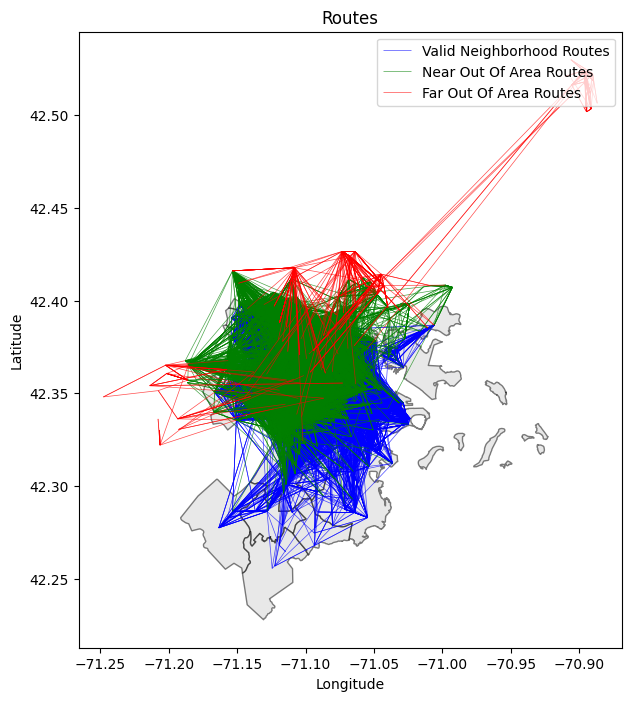

In [10]:
# Plot
fig, ax = plt.subplots(figsize=(12, 8))
neighborhoods.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5, label='Neighborhoods')
valid_routes.plot(ax=ax, color='blue', linewidth=0.5, label='Valid Neighborhood Routes', alpha=0.7)
near_out_of_area_routes.plot(ax=ax, color='green', linewidth=0.5, label='Near Out Of Area Routes', alpha=0.7)
far_out_of_area_routes.plot(ax=ax, color='red', linewidth=0.5, label='Far Out Of Area Routes', alpha=0.7)

# Add title and legend
plt.legend()
plt.title('Routes')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler


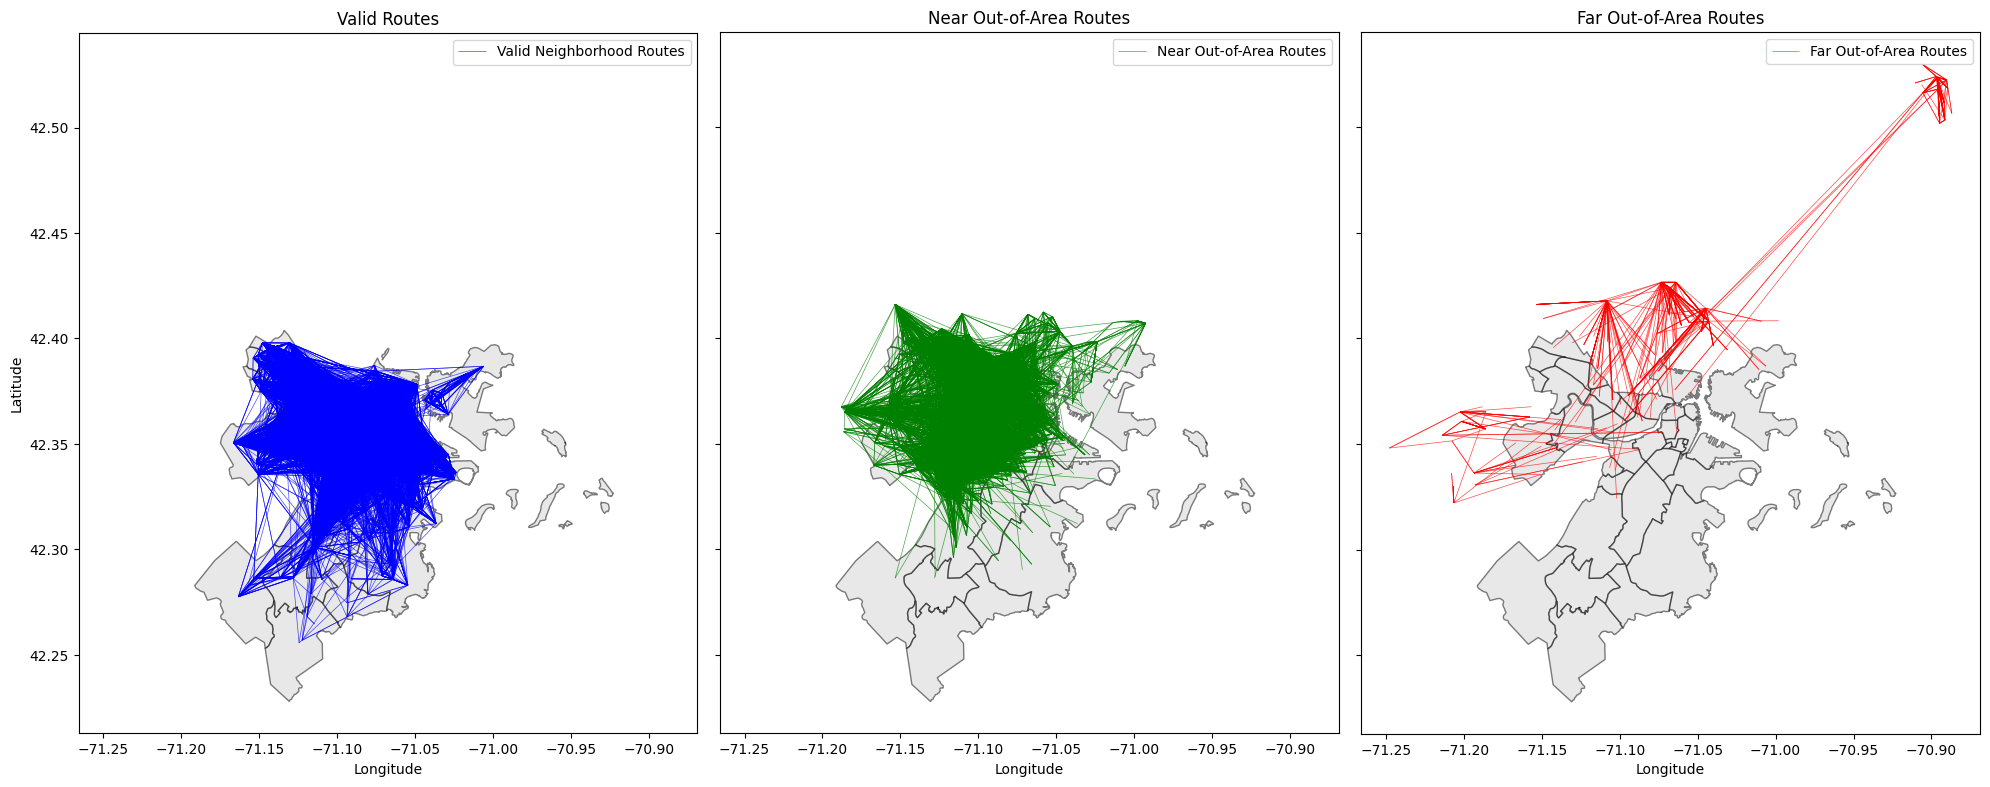

In [11]:
# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 8), sharex=True, sharey=True)

# Plot 1: Valid routes (blue)
neighborhoods.plot(ax=axes[0], color='lightgrey', edgecolor='black', alpha=0.5, label='Neighborhoods')
valid_routes.plot(ax=axes[0], color='blue', linewidth=0.5, label='Valid Neighborhood Routes', alpha=0.7)
axes[0].set_title('Valid Routes')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].legend()

# Plot 2: Near out-of-area routes (green)
neighborhoods.plot(ax=axes[1], color='lightgrey', edgecolor='black', alpha=0.5, label='Neighborhoods')
near_out_of_area_routes.plot(ax=axes[1], color='green', linewidth=0.5, label='Near Out-of-Area Routes', alpha=0.7)
axes[1].set_title('Near Out-of-Area Routes')
axes[1].set_xlabel('Longitude')
axes[1].legend()

# Plot 3: Far out-of-area routes (red)
neighborhoods.plot(ax=axes[2], color='lightgrey', edgecolor='black', alpha=0.5, label='Neighborhoods')
far_out_of_area_routes.plot(ax=axes[2], color='red', linewidth=0.5, label='Far Out-of-Area Routes', alpha=0.7)
axes[2].set_title('Far Out-of-Area Routes')
axes[2].set_xlabel('Longitude')
axes[2].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined plot
plt.show()
